## Práctica 1
### Elizaveta Gilyarovskaya
### Ejercicio 1: Cajas de mínima inclusión


https://stackoverflow.com/questions/59012906/custom-erosion-results-do-not-match-with-opencv-erosion

In [75]:
from PIL import Image
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from PIL import ImageOps

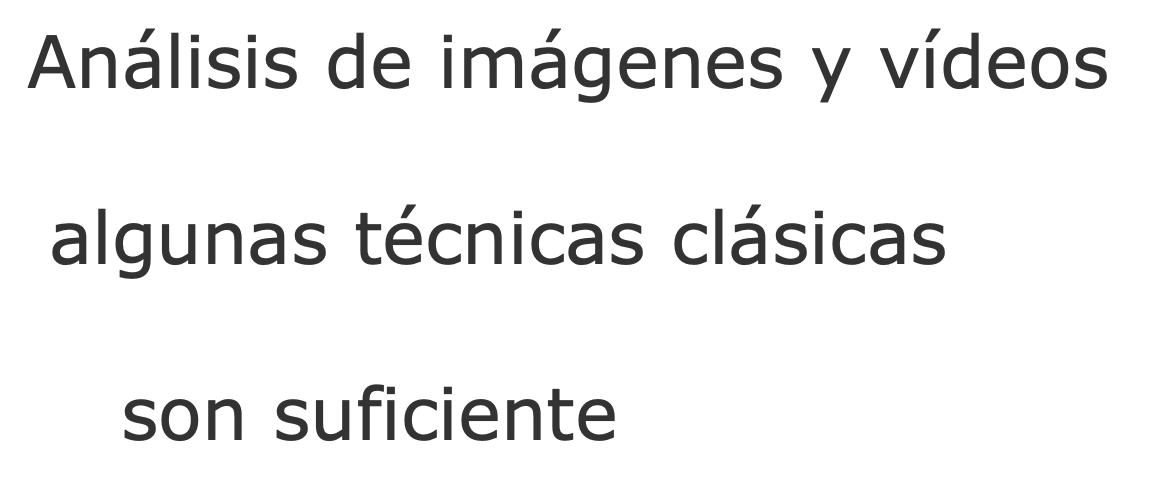

In [76]:
imagenes = [i for i in os.listdir() if i[-3::]== 'png']
word = Image.open(imagenes[2])
# Convertimos la imagen RGB a otro espacio de color donde tengamos en un plano la “luminancia”, como LAB.
# Asi solo utilizaremos la componente de luminaria, en este caso L.
if word.mode != "L":
    word = word.convert("L")
    
im = np.array(word)
Image.fromarray(im)

#### EL primer paso que haré es aplicar erosionado (del fondo en este caso ya que trabajaré con la imágen original en positivo) para que luego sea más fácil determinar las componentes conexas.

In [77]:
def Erosionado(I, kernel_size):
    kernel_size = 3 if kernel_size < 3 else kernel_size

    kernel = np.full(shape=(kernel_size, kernel_size), fill_value=255)
    
    pad_width = kernel_size - 2# tamaño óptimo de padding para la superposición del kernel

    # Aplicamos padding de tamaño óptimo
    padded = np.pad(array=I, pad_width=pad_width, mode='constant')

    # sub matrices of kernel size
    submatrices = np.array(
        [padded[i:(i + kernel_size), j:(j + kernel_size)]
        for i in range(padded.shape[0] - (padded.shape[0] - I.shape[0])) for j in range(padded.shape[1] - (padded.shape[1]-I.shape[1]))
        ])

    # condition to replace the values - if the kernel equal to submatrix then 255 else 0
    image_erode = np.array([255 if (i == kernel).all() else 0 for i in submatrices])
    image_erode = image_erode.reshape(I.shape)
    image_erode = np.uint8(np.clip(image_erode,0,255))
    
    return image_erode


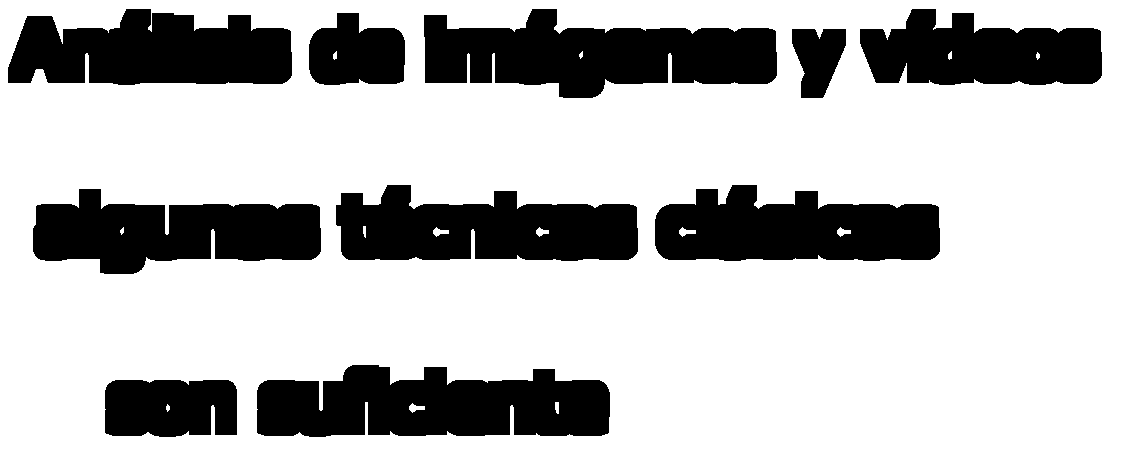

In [78]:
eroded = Erosionado(im, 15)
border = (18, 18, 4, 4) # left, top, right, bottom
eroded_fixed = ImageOps.crop(Image.fromarray(eroded), border)
eroded_fixed

In [79]:
eroded_fixed= np.array(eroded_fixed)

In [80]:
def get_cc(G, nodes, edges): # recibe un set de tuplas de enteros que representan las aristas entre los nodos(pixeles)
    for n in nodes:
        G.add_node(n)
    for n1,n2 in edges:
        G.add_edge(n1,n2)
  
    return list(nx.connected_components(G)) 

def Label(im):
             
    def get_label(i,j):
        four_connected = [(i,j-1), (i-1, j)] #si fuera 8-conectadas añadir además (i-1,j-1), (i-1, j+1)]
        values = []
        for i, j in four_connected:
            if not(i>=0 and j>=0 and i<im.shape[0] and j<im.shape[1]): continue # si no se da, next iteration
                
            #res inialmente se llena de pixeles de valor backgroud
            if res[i,j] != background: 
                values.append(int(res[i,j]))
        if len(values) == 0: 
            return prev_label + 1
        
        values = tuple(sorted(set((values))))
        ## Añadimos nuevos edges
        for edge_i in values[:-1]:
            for edge_j in values[1:]:
                edges.add((edge_i, edge_j))
        
        return values[0]
            
    b = int(input('Si el fondo es negro (imagen en negativo) introduzca 0, sino 1: '))
    background = 0 if b == 0 else 255
    G = nx.Graph()
    edges = set()
    nodes = set()
    prev_label = 0
    res = np.full((im.shape[0], im.shape[1]), background) 

    # 1: definimos y etiquetamos equivalencias
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i,j] != background:
                res[i,j] = get_label(i,j) #se saca la etiqueta de la componente correspondiente y se actualiza edges
                
                #Actualizamos la última equivalencia conocida
                if res[i,j] > prev_label:
                    prev_label = res[i,j]
                    
    # 2: resolvemos equivalencias
    for e in edges:
        nodes.update(e)
    connected_components = get_cc(G, nodes, edges)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for index, component in enumerate(connected_components):
                if res[i,j] in component:
                    res[i,j] = index +1
    
    # COLOREAR LAS COMPONENTES
    coloured_res = np.full((res.shape[0], res.shape[1], 3), background) #se puede devolver en positivo o en negativo dependiendo del background
    values = [mcolors.to_rgb(i) for i in mcolors.TABLEAU_COLORS.values()]    
    values = [(int(255*r), int(255*g), int(255*b)) for r,g,b, in values]
    colors = values[0:len(connected_components)]
    for index, color in enumerate(colors):
        connected_comp = index +1
        coloured_res[res == connected_comp,] = color
    
    return np.uint8(coloured_res),np.uint8(res) # devuelvo la versión coloreada y la gris 


In [81]:
labeled_color, labeled = Label(eroded_fixed)

Si el fondo es negro (imagen en negativo) introduzca 0, sino 1: 1


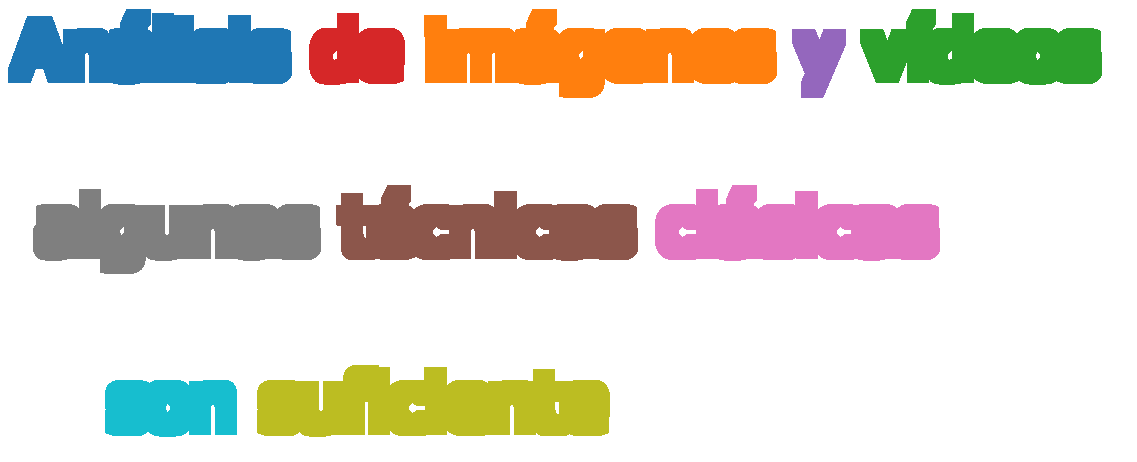

In [82]:
Image.fromarray(labeled_color)

## Cajas mínima inclusión

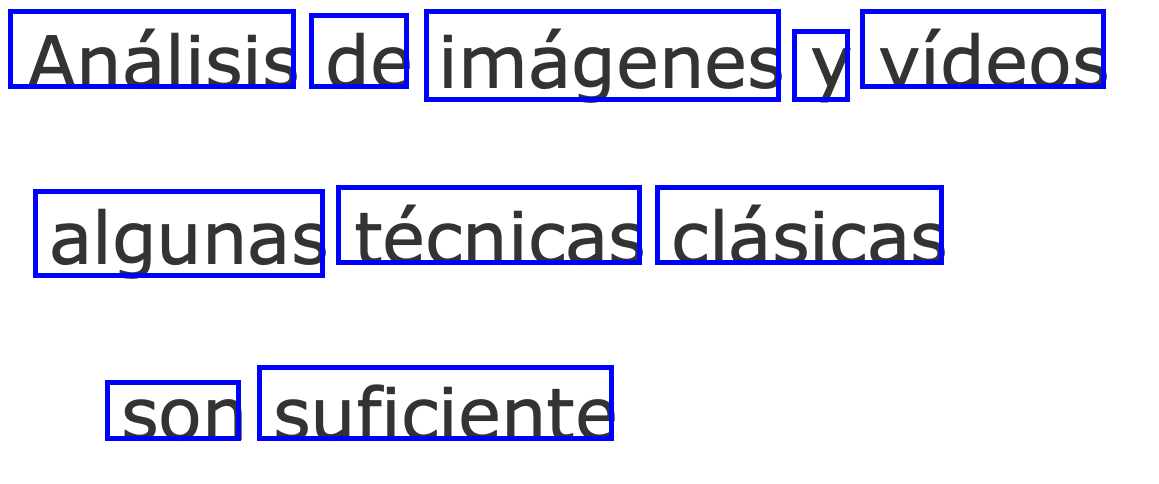

In [102]:
labels = [i for i in np.unique(labeled) if i!=255]
boxes = []
for label in labels:
    (x, y) = np.where(labeled == label)
    boxes.append((min(x), max(x), min(y), max(y)))
    
word_rgb = word.convert("RGB")
im_rgb = np.array(word_rgb)
blue = [0, 0, 255]
for min_x, max_x, min_y, max_y in boxes:
    im_rgb[max_x:max_x+5, min_y:max_y+5] = blue 
    im_rgb[min_x:min_x+5, min_y:max_y+5] = blue 
    im_rgb[min_x:max_x+5, min_y:min_y+5] = blue
    im_rgb[min_x:max_x+5, max_y:max_y+5] = blue 
    
  
    
Image.fromarray(np.uint8(im_rgb))
